# Flip-Flop RNN: fixed points & flow fields (DSATorch)

This notebook loads the trained flip-flop RNN, runs a few trials to collect hidden-state trajectories, and then uses **DSATorch** to:
- find fixed points from sampled hidden states
- visualize 2D flow fields around the trajectories
- inspect local linearization eigenvalues


In [1]:
# Imports and setup
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

# Make local DSATorch importable
repo_root = Path.cwd()
sys.path.append(str((repo_root / "DSATorch" / "src").resolve()))

from flip_flop_data import FlipFlopData
from model import Model

# dsatorch imports
from dsatorch.fixed_points.fp_finder import FixedPointFinder
from dsatorch.flow_fields.flow_field_finder import FlowFieldFinder
from dsatorch.linear.linearization import Linearization

from sklearn.decomposition import PCA
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)


# Flip Flop Task

The task is to implement a 3-bit binary memory, in which each of 3 input channels delivers signed
transient pulses (-1 or +1) to a corresponding bit of the memory, and an input pulse flips
the state of that memory bit (also -1 or +1) whenever a pulse’s sign is opposite of the
current state of the bit. 

In [2]:
# Load the trained flip-flop RNN
ckpt_path = "flip_flop_rnn.pth"
state_dict = torch.load(ckpt_path, map_location="cpu")

# Model hyperparameters used in training (see train.py)
n_bits = 3
n_hidden = 16

model = Model(n_bits, n_hidden, n_bits)
model.load_state_dict(state_dict)
model.eval()

print(model)


Model(
  (rnn): RNN(3, 16, batch_first=True)
  (out_layer): Linear(in_features=16, out_features=3, bias=True)
)


In [3]:
# Generate trials and collect hidden-state trajectories
n_trials = 64
n_time = 64

data_gen = FlipFlopData(n_bits=n_bits, n_time=n_time)
data = data_gen.generate_data(n_trials=n_trials)

inputs = torch.from_numpy(data["inputs"])

# Initial hidden state for the RNN
h0 = torch.zeros(1, n_trials, n_hidden)

with torch.no_grad():
    outputs, h_traj = model(inputs, h0)  # h_traj: [batch, time, hidden]

print("inputs:", inputs.shape)
print("outputs:", outputs.shape)
print("hidden trajectories:", h_traj.shape)

inputs: torch.Size([64, 64, 3])
outputs: torch.Size([64, 64, 3])
hidden trajectories: torch.Size([64, 64, 16])


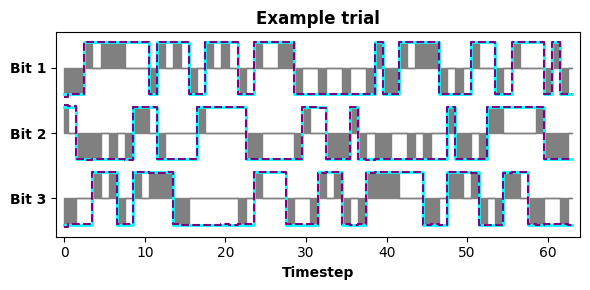

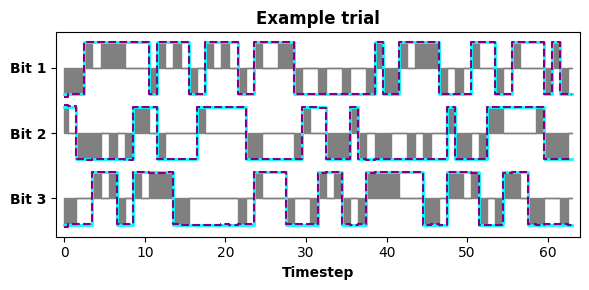

In [4]:
FlipFlopData.plot_trials(data, outputs.numpy())

# Fixed Point Finder

Consider a dynamical system 
$$\dot{x} = F(x)$$
We are interested in points $x^*$ at which this system will be approximately linear, which can be used to further mathematically or computationally analyze the system. Using the Taylor expansion we get 
$$F(x^* + \delta x) = F(x^*) + F'(x^*) + ...$$
At a fixed point $x^*$, we have that $F(x^*) = 0$, and therefore the first order term dominates the system. In this case, the system is approximately linear as opposed to affine, and we can safely ignore higher order terms as long as $\delta x$ is small. To find fixed points, we can numerically optimize for where the speed of the dynamics is slow, or nearly zero
$$q = \frac{1}{2}||F(x)||^2$$

In [ ]:
# Find fixed points using DSATorch
"""
First, we define a FixedPointFinder object with desired tolerances and settings.
Details of the parameters can be found in the DSATorch documentation.
Once a fixed point is found, a fixed point object is created that contains information
about the fixed point, such as the location, number of iterations to converge, etc.
"""
fpf = FixedPointFinder(model.rnn, tol_unique=1e-1, tol_q=1e-10, tol_dq=1e-18, max_iters=25000, verbose=True)

"""
Next, we sample initial states from the hidden state trajectories.
These initial states will be used as starting points for the fixed point search.
Pass in your trajectories and n_inits, n_inits will randomly sample that many states from the trajectories.
You can also add noise to the sampled states to help find more unique fixed points.
"""
# Sample initial states from trajectories
n_inits = 128
init_states = fpf.sample_states(h_traj, n_inits=n_inits, noise_scale=0.5)

# Use zero input (fixed points under no external drive)
ext_inp = torch.zeros(n_bits)

""" 
Finally, we call the find_fixed_points method with the initial states and external input.
This method returns two objects: unique_fps and all_fps.
"""
unique_fps, all_fps = fpf.find_fixed_points(init_states, ext_inp)
print("Unique fixed points:", unique_fps.n)



Searching for fixed points from 128 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.


/home/johnlazzari/miniconda3/envs/ml/lib/python3.14/site-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


	Maximum iteration count reached. Terminating.
		25000 iters
		q = 4.26e-08 +/- 4.52e-07
		dq = 1.60e-10 +/- 1.54e-09
		learning rate = 1.00e-04
		avg iter time = 3.88e-04 sectorch.Size([128, 16])
	Identified 25 unique fixed points.
	Fixed point finding complete.

Unique fixed points: 25


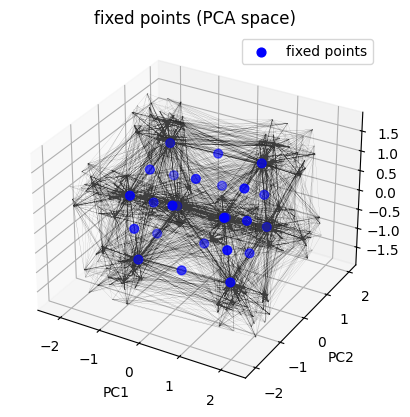

In [6]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Project fixed points into the same PCA space used by the flow field
# FlowFieldFinder uses an internal PCA fit on the provided trajectory
fp_states = unique_fps.xstar

pca = PCA(n_components=3)
fp_proj = pca.fit_transform(fp_states)
h_proj = pca.transform(h_traj.reshape(-1, n_hidden))
ax.scatter(fp_proj[:, 0], fp_proj[:, 1], fp_proj[:, 2], color="blue", s=40, label="fixed points")
ax.plot(h_proj[:, 0].T, h_proj[:, 1].T, h_proj[:, 2].T, color="black", alpha=0.75, linewidth=0.05)

ax.set_title("fixed points (PCA space)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()


# Flow Field Finder

Fixed points (or slow points) give us approximately linear systems to analyze. Additionally, we can explore the effective dyanmics of the network by generating velocity fields and energy landscapes (i.e. the speed of the system at different points). To do this, we generate a grid of points $X$, where a particular state of the system $x_{i,j} \in X$. Then, we compute 
$$\dot{x}_{i,j} = F(x_{i,j}) - x_{i,j}$$
To find the speed we take the magnitude
$$ ||\dot{x}_{i,j}||^2$$

/home/johnlazzari/dsatorch_examples/DSATorch/src/dsatorch/flow_fields/flow_field_finder.py:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverse_grid = torch.tensor(inverse_grid, dtype=self.dtype)
/home/johnlazzari/dsatorch_examples/DSATorch/src/dsatorch/flow_fields/flow_field_finder.py:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverse_grid = torch.tensor(inverse_grid, dtype=self.dtype)
/home/johnlazzari/dsatorch_examples/DSATorch/src/dsatorch/flow_fields/flow_field_finder.py:277: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


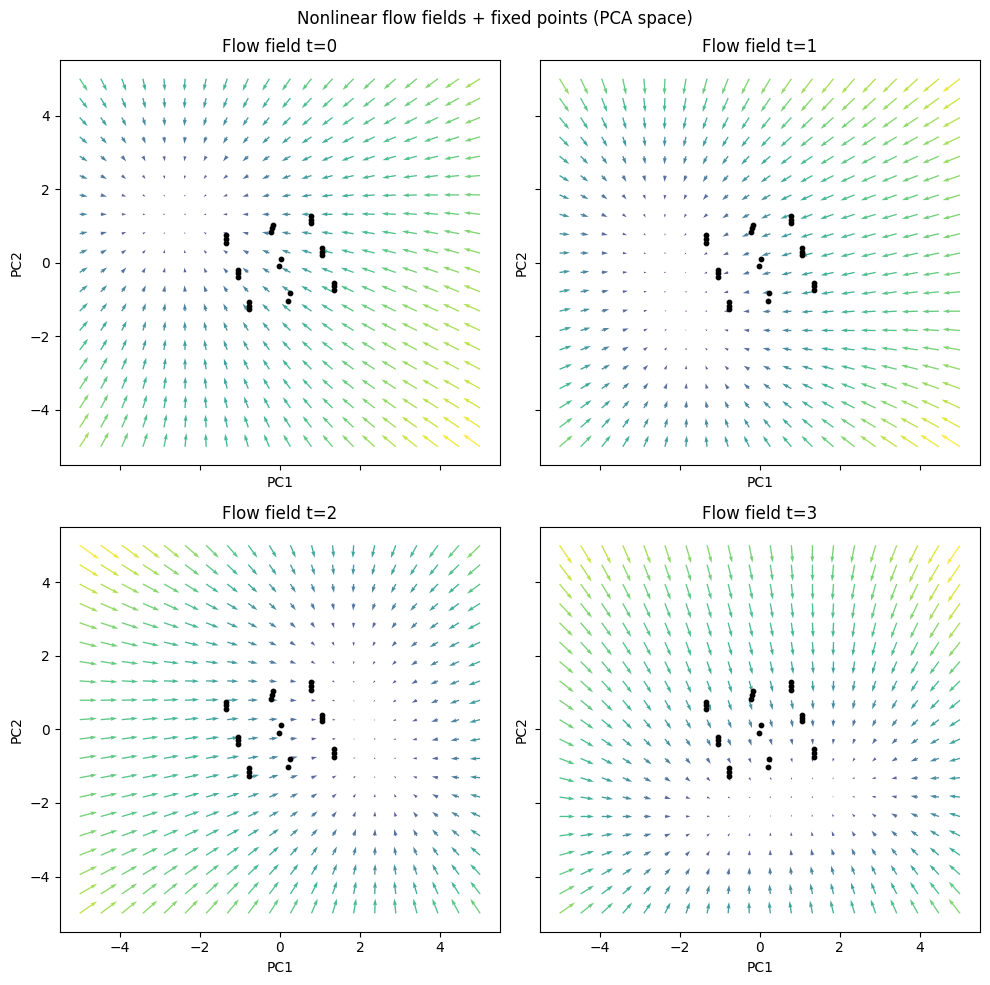

In [ ]:
# Flow field (nonlinear) + fixed points in 2D PCA space
"""
Similar to FixedPointFinder, we define a FlowFieldFinder object with desired settings.
Here, we specify the number of points in the grid, the offsets for the grid,
FlowFieldFinder will return flow field objects, which contain information about the grid points,
velocities at those points, speeds, etc.
"""
fff = FlowFieldFinder(model.rnn, num_points=20, x_offset=5, y_offset=5, follow_traj=False)
"""
There is no need to sample states for flow fields, simply pass in the desired states of any shape 
and a flow field for each one will be computed, along with its corresponding input (which must be of same shape)
"""
flow_fields = fff.find_nonlinear_flow(h_traj, inputs)

# Plot four flow fields in a 2x2 grid
n_show = min(4, len(flow_fields))
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Project fixed points into the same PCA space used by the flow field
fp_states = unique_fps.xstar
fp_proj = fff.reduce_obj.transform(fp_states)

for i in range(4):
    ax = axes[i]
    if i < n_show:
        ff = flow_fields[i]
        ax.quiver(
            ff.grid[..., 0],
            ff.grid[..., 1],
            ff.x_vels,
            ff.y_vels,
            ff.speeds,
            cmap="viridis",
            alpha=0.85,
        )
        ax.scatter(fp_proj[:, 0], fp_proj[:, 1], color="black", s=10)
        ax.set_title(f"Flow field t={i}")
    else:
        ax.axis("off")

fig.suptitle("Nonlinear flow fields + fixed points (PCA space)")
for ax in axes:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


# Linearization 

Despite finding fixed points, we did not yet linearize the network about these points. The linearization tool finds the jacobian of the network at a particular point and can decompose this jacobian. This is done for arbitrary points (currently only works for standard RNNs). The jacobian of the network will be given as 
$$J = \mathrm{diag}(\sigma'(x^*))W_h$$
The jacobian of the input weights are similarly given.

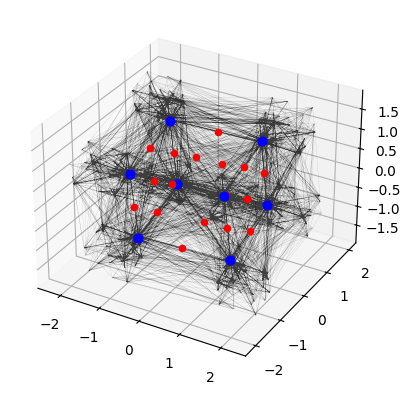

In [ ]:
# Linearization eigenvalues at fixed points
"""
Define a linearization object which takes in the rnn as the sole input currently
"""
lin = Linearization(model.rnn)

stability = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(unique_fps.n):
    """ 
    Currently, the linearization object has an eigendecomposition and jacobian method.
    Each method will take in a single 1D state at which to linearize the system
    """
    real, im, eigvec = lin.eigendecomposition(unique_fps.xstar[i])
    # get max eigenvalue
    max_eig = torch.max(real)
    if max_eig <= 1:
        stability.append(1)
    else:
        stability.append(0)

pca = PCA(n_components=3)
fp_proj = pca.fit_transform(fp_states)
h_proj = pca.transform(h_traj.reshape(-1, n_hidden))

for i in range(unique_fps.n):
    if stability[i] == 1:
        ax.scatter(fp_proj[i, 0], fp_proj[i, 1], fp_proj[i, 2], color="blue", s=40, label="fixed points")
    else:
        ax.scatter(fp_proj[i, 0], fp_proj[i, 1], fp_proj[i, 2], color="red", s=20, label="fixed points")
ax.plot(h_proj[:, 0].T, h_proj[:, 1].T, h_proj[:, 2].T, color="black", alpha=0.75, linewidth=0.05)

plt.show()


We can see that many of the fixed points we found were actually unstable! There are eight stable fixed points corresponding to each of the eight possible states in the task.